# Estimate p-Thyrosim parameters

In [1]:
using Distributed
addprocs(8)

@everywhere begin
    using DifferentialEquations
    using Thyrosim
    using DiffEqCallbacks
    using DiffEqParamEstim
    using SharedArrays
end

using Plots
using Optim

┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.2/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1240


      From worker 4:	┌ Warning: Module Compat with build ID 153655802098668 is missing from the cache.
      From worker 4:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 4:	└ @ Base loading.jl:1000
      From worker 5:	┌ Warning: Module Compat with build ID 153655802098668 is missing from the cache.
      From worker 5:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 5:	└ @ Base loading.jl:1000
      From worker 3:	┌ Warning: Module Compat with build ID 153655844448230 is missing from the cache.
      From worker 3:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1000
      From worker 4:	┌ Warning: Module Compat with build ID 153655802098668 is missing from

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquat

      From worker 6:	┌ Warning: Module Compat with build ID 153782982829558 is missing from the cache.
      From worker 6:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 6:	└ @ Base loading.jl:1000
      From worker 7:	┌ Warning: Module Compat with build ID 153783114286289 is missing from the cache.
      From worker 7:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 7:	└ @ Base loading.jl:1000
      From worker 4:	┌ Warning: Module Compat with build ID 153783114286289 is missing from the cache.
      From worker 4:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 4:	└ @ Base loading.jl:1000
      From worker 9:	┌ Warning: Module Compat with build ID 153783114286289 is missing from

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e]
│   exception = Required dependency Compat [34da2185-b29b-5c13-b0c7-acf172513d20] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e]
│   exception = Required dependency Compat [34da2185-b29b-5c13-b0c7-acf172513d20] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e]
│  

      From worker 5:	┌ Warning: Module DiffEqBase with build ID 153671545939434 is missing from the cache.
      From worker 5:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 5:	└ @ Base loading.jl:1000
      From worker 3:	┌ Warning: Module DiffEqBase with build ID 153672004100466 is missing from the cache.
      From worker 3:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1000
      From worker 5:	┌ Warning: Module DiffEqBase with build ID 153671545939434 is missing from the cache.
      From worker 5:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 5:	└ @ Base loading.jl:1000
      From worker 3:	┌ Warning: Module DiffEqBase with build ID 153

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e]
│   exception = Invalid input in module list: expected Compat.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025


      From worker 2:	┌ Warning: Module DiffEqBase with build ID 153797682377634 is missing from the cache.
      From worker 2:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1000
      From worker 6:	┌ Warning: Module DiffEqBase with build ID 153795029783641 is missing from the cache.
      From worker 6:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 6:	└ @ Base loading.jl:1000
      From worker 9:	┌ Warning: Module DiffEqBase with build ID 153795225435529 is missing from the cache.
      From worker 9:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 9:	└ @ Base loading.jl:1000
      From worker 4:	┌ Warning: Module DiffEqBase with build ID 153

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
│   exception = Required dependency NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] failed to load from a cache file.
└ @ Base loading.jl:1025


      From worker 8:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
      From worker 8:	│   exception = Required dependency LineSearches [d3d80556-e9d4-5f37-9878-2ab0fcc64255] failed to load from a cache file.
      From worker 8:	└ @ Base loading.jl:1025
      From worker 9:	┌ Warning: Module DiffEqBase with build ID 153795225435529 is missing from the cache.
      From worker 9:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 9:	└ @ Base loading.jl:1000
      From worker 4:	┌ Warning: Module DiffEqBase with build ID 153795284211919 is missing from the cache.
      From worker 4:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 4:	└ @ Base loading.jl:1000
      From worker 7:	┌ Warning: 

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SparseDiffTools [47a9eef4-7e08-11e9-0b38-333d64bd3804]
│   exception = Required dependency LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SparseDiffTools [47a9eef4-7e08-11e9-0b38-333d64bd3804]
│   exception = Required dependency LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d] failed to load from a cache file.
└ @ Base loading.jl:1025


      From worker 5:	┌ Warning: Module LightGraphs with build ID 153830440000729 is missing from the cache.
      From worker 5:	│ This may mean LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d] does not support precompilation but is imported by a module that does.
      From worker 5:	└ @ Base loading.jl:1000
      From worker 2:	┌ Warning: Module SimpleTraits with build ID 153826749975700 is missing from the cache.
      From worker 2:	│ This may mean SimpleTraits [699a6c99-e7fa-54fc-8d76-47d257e15c1d] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1000
      From worker 6:	┌ Warning: Module SimpleTraits with build ID 153826749975700 is missing from the cache.
      From worker 6:	│ This may mean SimpleTraits [699a6c99-e7fa-54fc-8d76-47d257e15c1d] does not support precompilation but is imported by a module that does.
      From worker 6:	└ @ Base loading.jl:1000
      From worker 4:	┌ Warning: Module MacroTools with bu

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SteadyStateDiffEq [9672c7b4-1e72-59bd-8a11-6ac3964bc41f]
│   exception = Required dependency SimpleTraits [699a6c99-e7fa-54fc-8d76-47d257e15c1d] failed to load from a cache file.
└ @ Base loading.jl:1025


      From worker 8:	┌ Warning: Module DiffEqBase with build ID 153798226668645 is missing from the cache.
      From worker 8:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 8:	└ @ Base loading.jl:1000
      From worker 6:	┌ Warning: Module DiffEqBase with build ID 153795029783641 is missing from the cache.
      From worker 6:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 6:	└ @ Base loading.jl:1000
      From worker 2:	┌ Warning: Module DiffEqBase with build ID 153797682377634 is missing from the cache.
      From worker 2:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1000


┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SteadyStateDiffEq [9672c7b4-1e72-59bd-8a11-6ac3964bc41f]
│   exception = Required dependency SimpleTraits [699a6c99-e7fa-54fc-8d76-47d257e15c1d] failed to load from a cache file.
└ @ Base loading.jl:1025


      From worker 4:	┌ Warning: Module DiffEqBase with build ID 153795284211919 is missing from the cache.
      From worker 4:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 4:	└ @ Base loading.jl:1000
      From worker 9:	┌ Warning: Module DiffEqBase with build ID 153795225435529 is missing from the cache.
      From worker 9:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 9:	└ @ Base loading.jl:1000
      From worker 7:	┌ Warning: Module DiffEqBase with build ID 153795275820548 is missing from the cache.
      From worker 7:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 7:	└ @ Base loading.jl:1000
      From worker 3:	┌ Warning: Module DiffEqBase with build ID 153

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SteadyStateDiffEq [9672c7b4-1e72-59bd-8a11-6ac3964bc41f]
│   exception = Required dependency SimpleTraits [699a6c99-e7fa-54fc-8d76-47d257e15c1d] failed to load from a cache file.
└ @ Base loading.jl:1025


      From worker 3:	┌ Warning: Module MacroTools with build ID 153786844861761 is missing from the cache.
      From worker 3:	│ This may mean MacroTools [1914dd2f-81c6-5fcd-8719-6d5c9610ff09] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1000
      From worker 5:	┌ Warning: Module DiffEqBase with build ID 153798226668645 is missing from the cache.
      From worker 5:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 5:	└ @ Base loading.jl:1000
      From worker 8:	┌ Warning: Module MacroTools with build ID 153786844861761 is missing from the cache.
      From worker 8:	│ This may mean MacroTools [1914dd2f-81c6-5fcd-8719-6d5c9610ff09] does not support precompilation but is imported by a module that does.
      From worker 8:	└ @ Base loading.jl:1000
      From worker 6:	┌ Warning: Module DiffEqBase with build ID 153

┌ Info: Precompiling Thyrosim [7ef34fca-2b35-11e9-1aeb-a527bedb189e]
└ @ Base loading.jl:1242
┌ Warning: Module VersionParsing with build ID 153414936969246 is missing from the cache.
│ This may mean VersionParsing [81def892-9a0e-5fdd-b105-ffc91e053289] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Warning: Module VersionParsing with build ID 153414936969246 is missing from the cache.
│ This may mean VersionParsing [81def892-9a0e-5fdd-b105-ffc91e053289] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Warning: Module VersionParsing with build ID 153414936969246 is missing from the cache.
│ This may mean VersionParsing [81def892-9a0e-5fdd-b105-ffc91e053289] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Warning: Module VersionParsing with build ID 153414936969246 is missing from the cache.
│ This may mean VersionParsing [81def892-9a0e-5f

      From worker 8:	┌ Warning: Module Compat with build ID 153783335811524 is missing from the cache.
      From worker 8:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 8:	└ @ Base loading.jl:1000
      From worker 6:	┌ Warning: Module Compat with build ID 153783335811524 is missing from the cache.
      From worker 6:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 6:	└ @ Base loading.jl:1000
      From worker 7:	┌ Warning: Module Compat with build ID 153783335811524 is missing from the cache.
      From worker 7:	│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
      From worker 7:	└ @ Base loading.jl:1000
      From worker 5:	┌ Warning: Module Compat with build ID 153783335811524 is missing from

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
│   exception = Required dependency StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
│   exception = Required dependency StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
│   exception = Required dependency StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
│   exception = Required depende

      From worker 2:	┌ Warning: Module DiffEqBase with build ID 153797682377634 is missing from the cache.
      From worker 2:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1000
      From worker 6:	┌ Warning: Module DiffEqBase with build ID 153795029783641 is missing from the cache.
      From worker 6:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 6:	└ @ Base loading.jl:1000
      From worker 7:	┌ Warning: Module DiffEqBase with build ID 153795275820548 is missing from the cache.
      From worker 7:	│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
      From worker 7:	└ @ Base loading.jl:1000
      From worker 9:	┌ Warning: Module DiffEqBase with build ID 153

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
│   exception = Required dependency StatsModels [3eaba693-59b7-5ba5-a881-562e759f1c8d] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
│   exception = Required dependency StatsModels [3eaba693-59b7-5ba5-a881-562e759f1c8d] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1242
┌ Warning: Module NLSolversBase with build ID 153457981288243 is missing from the cache.
│ This may mean NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing Optim [429524aa-4258-5aef-a3

      From worker 2:	┌ Warning: Module NLSolversBase with build ID 153816791646120 is missing from the cache.
      From worker 2:	│ This may mean NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1000
      From worker 6:	┌ Warning: Module NLSolversBase with build ID 153816791646120 is missing from the cache.
      From worker 6:	│ This may mean NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] does not support precompilation but is imported by a module that does.
      From worker 6:	└ @ Base loading.jl:1000
      From worker 9:	┌ Warning: Module NLSolversBase with build ID 153815356883952 is missing from the cache.
      From worker 9:	│ This may mean NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] does not support precompilation but is imported by a module that does.
      From worker 9:	└ @ Base loading.jl:1000
      From worker 8:	┌ Warning: Module NLSolversB

## Import data and initial conditions

In [2]:
#schneider data
train, test, toy = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

# Define error functions for the 3 datasets

## Blakesley

Used to fit TSH and T4 values. 

## Jonklaas

Used to fit T3 values.

## Schneider

Used as model verification. We simulate patients according to the number of days the patient achieved euthyrodism using the given dose, then calculate if their TSH levels are within [0.45, 4.5] mIU/ml.

## Parameter definition:
- `p[55]:` Daily T4 oral dose
- `p[56]:` Daily T3 oral dose

## Error definition:

For Blakesley and Jonklaas data, we calculate the residual loss between thyrosim and data. For Schneider data, the loss is defined as:

+ When given an euthyroid T4 dose, if any TSH values $\notin [0.5, 4.5]$ in the last 24h of simulation, then error + 1 (i.e. **patients receiving correct dose should have normal TSH**)
+ When given the initial T4 dose, if the initial T4 dose is not equal to euthyroid T4 dose, and all TSH values $\in [0.5, 4.5]$, then error + 1 (i.e. **patients not receiving correct dose should NOT have normal TSH**)

## Objective function 
+ `current_iter` stores only the parameters that are being optimized. 
+ `p` stores the full parameter vector. It is initialized separately for each patient and contains the parameters in `current_iter`. We update these parameters using `fitting_index`. 

In [39]:
function objective(
    p_being_optimized::Vector, 
    fitting_index::SharedArray, 
    blakesley_time::Vector,
    blakesley_my400_data::Matrix, 
    blakesley_my450_data::Matrix, 
    blakesley_my600_data::Matrix,
    jonklaas_time::Vector, 
    jonklaas_patient_t4::Matrix, 
    jonklaas_patient_t3::Matrix, 
    jonklaas_patient_tsh::Matrix, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    schneider_height::SharedArray, 
    schneider_weight::SharedArray, 
    schneider_sex::SharedArray, 
    schneider_tspan::SharedArray, 
    schneider_init_tsh::SharedArray, 
    schneider_euthy_dose::SharedArray, 
    schneider_init_dose::SharedArray;
    verbose::Bool = false #set to true to display intermediate errors
    )
    
    total_error = 0.0
    #
    # Blakesley
    #
    ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
    p[fitting_index] .= p_being_optimized
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
    # solve different ODE problems for varying doses
    p_400 = p_450 = p_600 = copy(p)
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=[1, 7])
    sol_450 = solve(prob_450, save_idxs=[1, 7])
    sol_600 = solve(prob_600, save_idxs=[1, 7])
    T4_error = blakesley_t4_error(sol_400, blakesley_time, blakesley_my400_data, p[47]) + 
               blakesley_t4_error(sol_450, blakesley_time, blakesley_my450_data, p[47]) + 
               blakesley_t4_error(sol_600, blakesley_time, blakesley_my600_data, p[47])
    TSH_error = blakesley_tsh_error(sol_400, blakesley_time, blakesley_my400_data, p[48]) + 
                blakesley_tsh_error(sol_450, blakesley_time, blakesley_my400_data, p[48]) + 
                blakesley_tsh_error(sol_600, blakesley_time, blakesley_my400_data, p[48])
    blakesley_err = 0.01T4_error + TSH_error
    verbose && println("blakesley error = $blakesley_err")
    total_error += blakesley_err
    #
    # Jonklaas
    #
    tspan = (0.0, 8.0)
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    jonklaas_err = 0.0
    for i in 1:size(patient_param, 1)
        # initialize ODE problem for patient 1
        height, weight, sex = jonklaas_patient_param[i, :]
        T4init, T3init, TSHinit = jonklaas_patient_t4[i, 1], jonklaas_patient_t3[i, 1], jonklaas_patient_tsh[i, 1]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        # set parameters being fitted
        p[fitting_index] .= p_being_optimized
        # solve different ODE problems for varying doses
        p[56] = jonklaas_patient_dose[i] / 651.0
        prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
        sol  = solve(prob, save_idxs=4)
        jonklaas_err += jonklaas_error(sol, jonklaas_time, jonklaas_patient_t3[i, :], p[47])
    end
    verbose && println("jonklaas error = $jonklaas_err")
    total_error += jonklaas_err
    #
    # Schneider
    #
    num_params = length(p_being_optimized)
    num_sample = length(schneider_height)
    num_params == length(fitting_index) || error("check parameter length bro")
    current_iter = SharedArray{Float64}(p_being_optimized)
    schneider_err = @sync @distributed (+) for i in 1:num_sample
        one_simulation(current_iter, fitting_index, schneider_height[i], 
            schneider_weight[i], schneider_sex[i], schneider_tspan[i], schneider_init_tsh[i], 
            schneider_euthy_dose[i], schneider_init_dose[i])
    end
    verbose && println("schneider error = $schneider_err")
    total_error += schneider_err
    #
    # Return final error
    #
    return total_error
end

objective (generic function with 6 methods)

### Parallel version of previous function using the Distributed package

In [19]:
@everywhere function one_simulation(
    current_iter::SharedArray,
    fitting_index::SharedArray, 
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    initial_tsh::Float64,
    euthyroid_dose::Float64,
    initial_dose::Float64
    )
    
    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= current_iter
    
    # calculate error for euthyroid dose
    p[55] = euthyroid_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
    sol   = solve(prob, save_idxs=7)
    
    #increment error
    tot_loss += compute_euthyroid_dose_error(sol)
    
    # when initial dose != euthyroid dose, calculate error
    if initial_dose != euthyroid_dose
        p[55] = initial_dose / 777.0
        prob = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol = solve(prob, save_idxs=7)
        tot_loss += compute_initial_dose_error(sol)
    end

    return tot_loss
end

### Helper functions for calculating error

In [7]:
# gives 400 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end

# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end

# define function for adding dose
@everywhere function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end

@everywhere function compute_euthyroid_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if !all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end

@everywhere function compute_initial_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
                        
function blakesley_tsh_error(sol, time, data, Vtsh)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[2] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 2])^2
        end
    end
    return tot_loss
end
            
function blakesley_t4_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
    end
    return tot_loss
end
                                                
function jonklaas_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
    end
    return tot_loss
end

jonklaas_error (generic function with 1 method)

# Test fitting on toy data of schneider

In [22]:
function fit_all()
    # initialize initial guess and fitting index
    fitting_index = SharedArray{Int}([28; 45; 30; 31; 49; 50; 51; 52; 53; 54])
    initial_guess = [0.4978; 1.78; 101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

    # blakesley setup 
    blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
    data_400 = [my400_data[:, 1] my400_data[:, 3]] # [T4 TSH]
    data_450 = [my450_data[:, 1] my450_data[:, 3]]
    data_600 = [my600_data[:, 1] my600_data[:, 3]]
    
    # jonklaas setup
    jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
    jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
    
    # schneider setup
    train_data = toy
    height = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Ht.m")]))
    weight = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")]))
    sex    = SharedArray{Bool}(convert(Vector{Bool}, train_data[!, Symbol("Sex")]))
    tspan  = SharedArray{Float64}(convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")]))
    init_tsh   = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")]))
    euthy_dose = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")]))
    init_dose  = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")]))
    
    return optimize(p -> objective(p, fitting_index, 
                                   blakesley_time, data_400, data_450, data_600,
                                   jonklaas_time, patient_t4, patient_t3, patient_tsh, patient_param, jonklaas_patient_dose,
                                   height, weight, sex, tspan, init_tsh, euthy_dose, init_dose), 
                        initial_guess, NelderMead(), Optim.Options(iterations = 500))
end

fit_all (generic function with 1 method)

In [23]:
result = fit_all()

 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [8.89e-01, 1.69e+00, 6.99e+01,  ...]
    Minimum:   7.393083e+01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [4.98e-01, 1.78e+00, 1.01e+02,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   632  (vs limit Inf)
    Iterations:    500
    f(x) calls:    860


In [25]:
initial_guess = [0.4978; 1.78; 101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

[initial_guess result.minimizer]

10×2 Array{Float64,2}:
   0.4978   0.889207
   1.78     1.68822 
 101.0     69.9038  
  47.64    38.7116  
   4.57     6.03989 
   3.9      3.70066 
  11.0      8.74819 
   5.0      6.59069 
   3.5      2.89655 
   8.0     13.0132  

## Check respective error contribution

In [42]:
# initialize initial guess and fitting index
fitting_index = SharedArray{Int}([28; 45; 30; 31; 49; 50; 51; 52; 53; 54])
initial_guess = [0.4978; 1.78; 101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]
# blakesley setup 
blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
data_400 = [my400_data[:, 1] my400_data[:, 3]] # [T4 TSH]
data_450 = [my450_data[:, 1] my450_data[:, 3]]
data_600 = [my600_data[:, 1] my600_data[:, 3]]
# jonklaas setup
jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
# schneider setup
train_data = toy
height = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Ht.m")]))
weight = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")]))
sex    = SharedArray{Bool}(convert(Vector{Bool}, train_data[!, Symbol("Sex")]))
tspan  = SharedArray{Float64}(convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")]))
init_tsh   = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")]))
euthy_dose = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")]))
init_dose  = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")]));

#### Pre-optimizing

In [43]:
objective(initial_guess, fitting_index, 
          blakesley_time, data_400, data_450, data_600,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

blakesley error = 1913.1989615316286
jonklaas error = 37.366765574536
schneider error = 15


1965.5657271061646

#### Post-optimizing
Ideally the 3 errors should be roughly the same

In [44]:
objective(result.minimizer, fitting_index, 
          blakesley_time, data_400, data_450, data_600,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

blakesley error = 33.03321338016419
jonklaas error = 27.897619254690383
schneider error = 13


73.93083263485457

## Check if result matches data

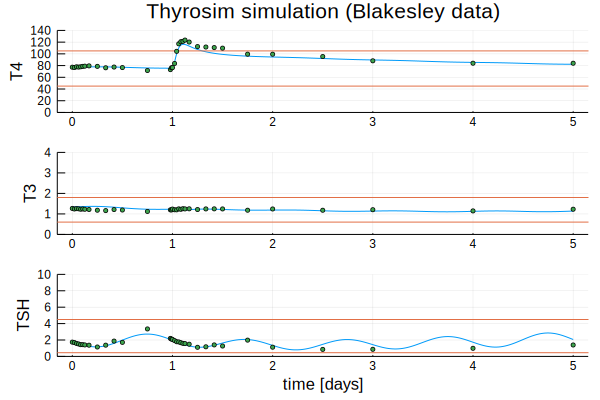

In [52]:
# blakesley 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[55] = 400 / 777.0
p[56] = 0.0
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
p[fitting_index] = result.minimizer
prob = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
new_sol = solve(prob)
plot_blakesley(new_sol, "400")

In [56]:
# jonklaas
graphs = Vector{Any}(undef, 15)
for i in 1:15
    height, weight, sex = patient_param[i, :]
    T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
    T3dose = patient_dose[i]
    ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
    set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
    p[55] = 0.0
    p[56] = T3dose / 651.0
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    p[fitting_index] = result.minimizer
    prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
    sol = solve(prob)
    graphs[i] = plot_jonklaas(sol, patient_t4[i, :], patient_t3[i, :], patient_tsh[i, :])
end

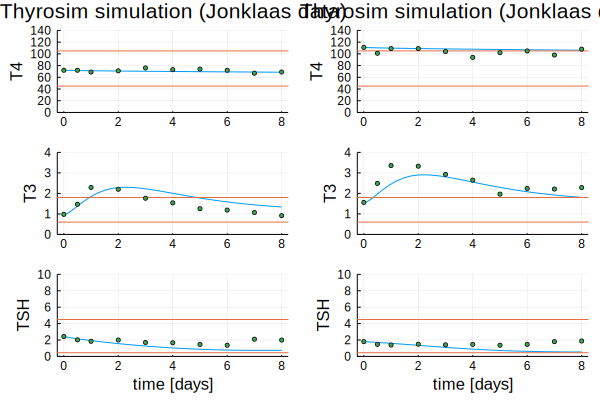

In [71]:
# plot(graphs..., layout=(1, 15))
plot(graphs[1], graphs[2], layout=(1, 2))

# Fitting on full training data